# Image classification with Perceiver on cifar-10 dataset  
1. Instead of the cifar-100, the cifar-10 dataset is used 
2. To cut traning time from ~2hours 
   - Image classification problem has been reduced to 2 classses  
   - 5 epoch training is performed to cut runtime 

[Reference](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/perceiver_image_classification.ipynb) 



# Setup

In [16]:
pip install -U tensorflow-addons

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Read in the images

In [33]:
num_classes = 2
input_shape = (32, 32, 3)

(xtrain, ytrain), (xtest, ytest) = keras.datasets.cifar10.load_data()

# Reduce the number of images further to cut training time from ~2hours
x_train = []
y_train = []
for i, y in enumerate(ytrain):
  if y < 2:
    x_train.append(xtrain[i])
    y_train.append(y)

x_test = []
y_test = []
for i, y in enumerate(ytest):
  if y < 2:
    x_test.append(xtest[i])
    y_test.append(y)

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (10000, 32, 32, 3) - y_train shape: (10000, 1)
x_test shape: (2000, 32, 32, 3) - y_test shape: (2000, 1)


# Visualize some images

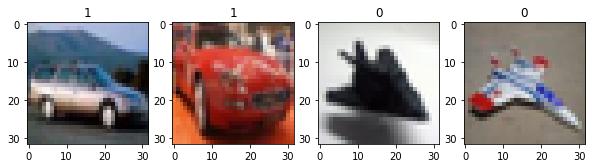

In [34]:
# Plot a few images
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 4, figsize=(10,10))
for i, ax in enumerate(axis.flat):
    ax.set_title(y_train[i][0])
    ax.imshow(x_train[i])
plt.show()

# Configure the hyperparameters, 10 epoch training

In [35]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 5
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 2  # Size of the patches to be extract from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
latent_dim = 256  # Size of the latent array.
projection_dim = 256  # Embedding size of each element in the data and latent arrays.
num_heads = 8  # Number of Transformer heads.
ffn_units = [
    projection_dim,
    projection_dim,
]  # Size of the Transformer Feedforward network.
num_transformer_blocks = 4
num_iterations = 2  # Repetitions of the cross-attention and Transformer modules.
classifier_units = [
    projection_dim,
    num_classes,
]  # Size of the Feedforward network of the final classifier.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")
print(f"Latent array shape: {latent_dim} X {projection_dim}")
print(f"Data array shape: {num_patches} X {projection_dim}")

Image size: 64 X 64 = 4096
Patch size: 2 X 2 = 4 
Patches per image: 1024
Elements per patch (3 channels): 12
Latent array shape: 256 X 256
Data array shape: 1024 X 256


Note that, in order to use each pixel as an individual input in the data array,
set `patch_size` to 1.

# Use data augmentation

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

# Build the model
## 1. Feedforward network (FFN)  
## 2. Add patch encoder layer 
## 3. Add perceiver with cross attention, transformer and perceiver  


## Implement Feedforward network (FFN)

In [37]:
# Feedforward network
def create_ffn(hidden_units, dropout_rate):
    ffn_layers = []
    for units in hidden_units[:-1]:
        ffn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    ffn_layers.append(layers.Dense(units=hidden_units[-1]))
    ffn_layers.append(layers.Dropout(dropout_rate))

    ffn = keras.Sequential(ffn_layers)
    return ffn


## Implement patch creation as a layer

In [38]:
# Patch encoder layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into
a vector of size `latent_dim`. In addition, it adds a learnable position embedding
to the projected vector.

Note that the orginal Perceiver paper uses the Fourier feature positional encodings.

In [39]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


## Build the Perceiver model

The Perceiver consists of two modules: a cross-attention
module and a standard Transformer with self-attention.

### Cross-attention module

The cross-attention expects a `(latent_dim, projection_dim)` latent array,
and the `(data_dim,  projection_dim)` data array as inputs,
to produce a `(latent_dim, projection_dim)` latent array as an output.
To apply cross-attention, the `query` vectors are generated from the latent array,
while the `key` and `value` vectors are generated from the encoded image.

Note that the data array in this example is the image,
where the `data_dim` is set to the `num_patches`.

In [40]:

def create_cross_attention_module(
    latent_dim, data_dim, projection_dim, ffn_units, dropout_rate
):

    inputs = {
        # Recieve the latent array as an input of shape [1, latent_dim, projection_dim].
        "latent_array": layers.Input(shape=(latent_dim, projection_dim)),
        # Recieve the data_array (encoded image) as an input of shape [batch_size, data_dim, projection_dim].
        "data_array": layers.Input(shape=(data_dim, projection_dim)),
    }

    # Apply layer norm to the inputs
    latent_array = layers.LayerNormalization(epsilon=1e-6)(inputs["latent_array"])
    data_array = layers.LayerNormalization(epsilon=1e-6)(inputs["data_array"])

    # Create query tensor: [1, latent_dim, projection_dim].
    query = layers.Dense(units=projection_dim)(latent_array)
    # Create key tensor: [batch_size, data_dim, projection_dim].
    key = layers.Dense(units=projection_dim)(data_array)
    # Create value tensor: [batch_size, data_dim, projection_dim].
    value = layers.Dense(units=projection_dim)(data_array)

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attention_output = layers.Attention(use_scale=True, dropout=0.1)(
        [query, key, value], return_attention_scores=False
    )
    # Skip connection 1.
    attention_output = layers.Add()([attention_output, latent_array])

    # Apply layer norm.
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
    # Apply Feedforward network.
    ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
    outputs = ffn(attention_output)
    # Skip connection 2.
    outputs = layers.Add()([outputs, attention_output])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


### Transformer module

The Transformer expects the output latent vector from the cross-attention module
as an input, applies multi-head self-attention to its `latent_dim` elements,
followed by feedforward network, to produce another `(latent_dim, projection_dim)` latent array.

In [41]:

def create_transformer_module(
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
):

    # input_shape: [1, latent_dim, projection_dim]
    inputs = layers.Input(shape=(latent_dim, projection_dim))

    x0 = inputs
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        # Apply layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x0)
        # Create a multi-head self-attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x0])
        # Apply layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Apply Feedforward network.
        ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
        x3 = ffn(x3)
        # Skip connection 2.
        x0 = layers.Add()([x3, x2])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=x0)
    return model


### Perceiver model

The Perceiver model repeats the cross-attention and Transformer modules
`num_iterations` times—with shared weights and skip connections—to allow
the latent array to iteratively extract information from the input image as it is needed.

In [42]:

class Perceiver(keras.Model):
    def __init__(
        self,
        patch_size,
        data_dim,
        latent_dim,
        projection_dim,
        num_heads,
        num_transformer_blocks,
        ffn_units,
        dropout_rate,
        num_iterations,
        classifier_units,
    ):
        super(Perceiver, self).__init__()

        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.ffn_units = ffn_units
        self.dropout_rate = dropout_rate
        self.num_iterations = num_iterations
        self.classifier_units = classifier_units

    def build(self, input_shape):
        # Create latent array.
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer="random_normal",
            trainable=True,
        )

        # Create patching module.
        self.patcher = Patches(self.patch_size)

        # Create patch encoder.
        self.patch_encoder = PatchEncoder(self.data_dim, self.projection_dim)

        # Create cross-attenion module.
        self.cross_attention = create_cross_attention_module(
            self.latent_dim,
            self.data_dim,
            self.projection_dim,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create Transformer module.
        self.transformer = create_transformer_module(
            self.latent_dim,
            self.projection_dim,
            self.num_heads,
            self.num_transformer_blocks,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create global average pooling layer.
        self.global_average_pooling = layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = create_ffn(
            hidden_units=self.classifier_units, dropout_rate=self.dropout_rate
        )

        super(Perceiver, self).build(input_shape)

    def call(self, inputs):
        # Augment data.
        augmented = data_augmentation(inputs)
        # Create patches.
        patches = self.patcher(augmented)
        # Encode patches.
        encoded_patches = self.patch_encoder(patches)
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": tf.expand_dims(self.latent_array, 0),
            "data_array": encoded_patches,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for _ in range(self.num_iterations):
            # Apply cross-attention from the latent array to the data array.
            latent_array = self.cross_attention(cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = self.transformer(latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        representation = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(representation)
        return logits


# Compile, train, and evaluate the model

In [43]:

def run_experiment(model):

    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.LAMB(
        learning_rate=learning_rate, weight_decay_rate=weight_decay,
    )

    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=3
    )

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )

    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


Note that training the perceiver model with the current settings on a V100 GPUs takes
around 200 seconds.

In [44]:
perceiver_classifier = Perceiver(
    patch_size,
    num_patches,
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
    num_iterations,
    classifier_units,
)


history = run_experiment(perceiver_classifier)

Epoch 1/5
141/141 [==============================] - 1523s 11s/step - loss: 0.6261 - acc: 0.6498 - top5-acc: 1.0000 - val_loss: 0.5197 - val_acc: 0.7670 - val_top5-acc: 1.0000
Epoch 2/5
141/141 [==============================] - 1483s 11s/step - loss: 0.5418 - acc: 0.7236 - top5-acc: 1.0000 - val_loss: 0.4319 - val_acc: 0.8090 - val_top5-acc: 1.0000
Epoch 3/5
141/141 [==============================] - 1488s 11s/step - loss: 0.4972 - acc: 0.7606 - top5-acc: 1.0000 - val_loss: 0.4047 - val_acc: 0.8240 - val_top5-acc: 1.0000
Epoch 4/5
141/141 [==============================] - 1488s 11s/step - loss: 0.4605 - acc: 0.7804 - top5-acc: 1.0000 - val_loss: 0.3811 - val_acc: 0.8390 - val_top5-acc: 1.0000
Epoch 5/5
63/63 [==============================] - 129s 2s/step - loss: 0.3622 - acc: 0.8420 - top5-acc: 1.0000
Test accuracy: 84.2%
Test top 5 accuracy: 100.0%


After 5 epochs, the Perceiver model on the cifar-10 dataset achieved 84.2% accuracy and 100% top-5 accuracy on the test data.